In [ ]:
import pandas as pd
import numpy as np
import torch
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils import shuffle
from nltk.tokenize import word_tokenize
from collections import Counter
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
import kagglehub
path = kagglehub.dataset_download("nelgiriyewithana/emotions")
print("Path to dataset files:", path)

df = pd.read_csv('/kaggle/input/emotions/text.csv', skiprows=1, names=["id_text", "text", "label"])
print(df['label'].unique())

Path to dataset files: /kaggle/input/emotions
[4 0 2 1 5 3]


In [ ]:
label_encoder = LabelEncoder()
df['encoded_label'] = label_encoder.fit_transform(df['label'])
df = shuffle(df, random_state=42).reset_index(drop=True)

train_df, temp_df = train_test_split(
    df, test_size=0.3, stratify=df['encoded_label'], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df['encoded_label'], random_state=42
)

def build_vocab(texts, min_freq=2):
    counter = Counter()
    for text in texts:
        tokens = word_tokenize(text.lower())
        counter.update(tokens)

    vocab = {'<PAD>': 0, '<UNK>': 1}
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)
    return vocab

vocab = build_vocab(train_df['text'],min_freq=2)

In [ ]:
class EmotionDataset(Dataset):
    def __init__(self, df, vocab, max_len=50):
        self.texts = df['text'].tolist()
        self.labels = df['encoded_label'].tolist()
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        tokens = word_tokenize(self.texts[idx].lower())
        indices = [self.vocab.get(token, self.vocab['<UNK>']) for token in tokens]
        if len(indices) < self.max_len:
            indices += [self.vocab['<PAD>']] * (self.max_len - len(indices))
        else:
            indices = indices[:self.max_len]
        return torch.tensor(indices), torch.tensor(self.labels[idx])

train_dataset = EmotionDataset(train_df, vocab)
val_dataset = EmotionDataset(val_df, vocab)
test_dataset = EmotionDataset(test_df, vocab)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embeds = self.embedding(x)
        _, (hidden, _) = self.lstm(embeds)
        out = self.fc(hidden[-1])
        return out

model = LSTMModel(len(vocab), embed_dim=200, hidden_dim=256, output_dim=len(label_encoder.classes_))

In [ ]:
def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return avg_loss, acc, f1

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


for epoch in range(30):
    model.train()
    total_train_loss = 0
    all_train_preds, all_train_labels = [], []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        all_train_preds.extend(preds.cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy())

    train_acc = (np.array(all_train_preds) == np.array(all_train_labels)).mean()
    train_f1 = f1_score(all_train_labels, all_train_preds, average='macro')
    avg_train_loss = total_train_loss / len(train_loader)

    val_loss, val_acc, val_f1 = evaluate(model, val_loader, criterion)

    print(f"Epoch {epoch+1}: "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

Epoch 1: Train Loss: 1.5753, Train Acc: 0.3371, Train F1: 0.0903 | Val Loss: 1.5745, Val Acc: 0.3380, Val F1: 0.0850
Epoch 2: Train Loss: 1.5713, Train Acc: 0.3403, Train F1: 0.0933 | Val Loss: 1.4446, Val Acc: 0.4656, Val F1: 0.2004
Epoch 3: Train Loss: 0.2488, Train Acc: 0.8903, Train F1: 0.8430 | Val Loss: 0.1096, Val Acc: 0.9338, Val F1: 0.9031
Epoch 4: Train Loss: 0.0991, Train Acc: 0.9384, Train F1: 0.9063 | Val Loss: 0.1022, Val Acc: 0.9367, Val F1: 0.9008
Epoch 5: Train Loss: 0.0926, Train Acc: 0.9400, Train F1: 0.9075 | Val Loss: 0.1022, Val Acc: 0.9358, Val F1: 0.9014
Epoch 6: Train Loss: 0.0887, Train Acc: 0.9418, Train F1: 0.9097 | Val Loss: 0.1043, Val Acc: 0.9350, Val F1: 0.8979
Epoch 7: Train Loss: 0.0863, Train Acc: 0.9429, Train F1: 0.9110 | Val Loss: 0.1029, Val Acc: 0.9336, Val F1: 0.9033
Epoch 8: Train Loss: 0.0836, Train Acc: 0.9436, Train F1: 0.9113 | Val Loss: 0.1055, Val Acc: 0.9336, Val F1: 0.8986
Epoch 9: Train Loss: 0.0824, Train Acc: 0.9445, Train F1: 0.9128

In [ ]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

target_names = [str(label) for label in sorted(test_df['label'].unique())]

print(classification_report(all_labels, all_preds, target_names=target_names))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97     18178
           1       0.94      0.94      0.94     21160
           2       0.80      0.79      0.79      5183
           3       0.91      0.94      0.93      8598
           4       0.85      0.88      0.87      7157
           5       0.74      0.71      0.72      2246

    accuracy                           0.92     62522
   macro avg       0.87      0.87      0.87     62522
weighted avg       0.92      0.92      0.92     62522



In [11]:
test_loss, test_acc, test_f1 = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}, F1-score: {test_f1:.4f}")

Test Loss: 0.1892, Accuracy: 0.9174, F1-score: 0.8695


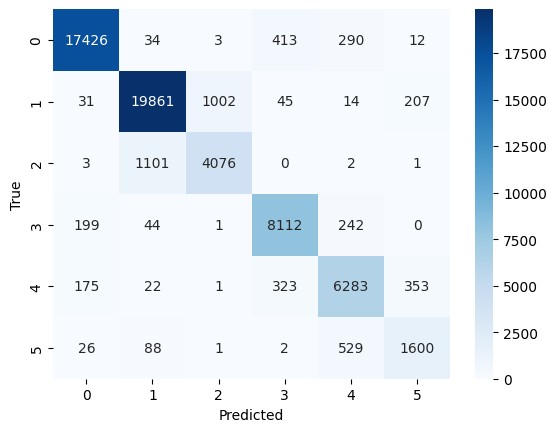

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()